In [1]:
%matplotlib ipympl
import time
import pandas
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.units import ureg
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from uncertainties import ufloat, unumpy
from datetime import datetime

In [30]:
def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

In [2]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [147]:
def get_average_heights(data_number, pretect):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None

    if pretect:
        antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        if pretect:
            antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        if pretect:
            antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    if "lf" in transmissions_avg:
        lf_normalized = transmissions_avg["lf"] / monitors_avg["lf"]
    
    if headers["params"]["field_plate"]["use"]:
        if "use_opposite_field" not in headers["params"]["field_plate"]:
            hat_E = (headers["params"]["field_plate"]["amplitude"] > 0)
        else:
            hat_E = (headers["params"]["field_plate"]["amplitude"] > 0) == (not headers["params"]["field_plate"]["use_opposite_field"])
        hat_probe = headers["params"]["field_plate"]["stark_shift"] > 0
        mask = detunings_MHz > 0
        mask1 = detunings_MHz < 0
        if "lf" in transmissions_avg:
            return (np.array([np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])]), 
            np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), 
            np.array([np.average(lf_normalized[mask]), np.average(lf_normalized[mask1])]), headers, (hat_E, hat_probe))
        else:
            if pretect:
                return (
                    np.array([
                        np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])
                    ]),
                    np.array([
                        np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])
                    ]),
                    np.array([
                        np.std(antihole_normalized[mask]) / np.sqrt(len(antihole_normalized[mask])), np.std(antihole_normalized[mask1]) / np.sqrt(len(antihole_normalized[mask1]))
                    ]),
                    np.array([
                        np.std(rf_normalized[mask]) / np.sqrt(len(antihole_normalized[mask])), np.std(rf_normalized[mask1]) / np.sqrt(len(antihole_normalized[mask1]))
                    ]),
                    headers,
                    (hat_E, hat_probe),
                )
            else:
                return (
                    np.array([
                        np.nan, np.nan
                    ]),
                    np.array([
                        np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])
                    ]),
                    np.array([
                        np.nan, np.nan
                    ]),
                    np.array([
                        np.std(rf_normalized[mask]) / np.sqrt(len(rf_normalized[mask])), np.std(rf_normalized[mask1]) / np.sqrt(len(rf_normalized[mask1]))
                    ]),
                    headers,
                    (hat_E, hat_probe),
                )
            
    else:
        return np.average(antihole_normalized), np.average(rf_normalized), headers, None

def get_voltage_ratios(data_list, pretect = True):
    ratios = []
    ratios_err = []
    ratios2 = []
    headers = []
    E_fields = []
    # for kk in data_list:
    #     h1, h2, h3, header, E_field = get_average_heights(kk)
    #     ratios.append(h2 / h1)
    #     ratios2.append((h3-h2)/(h2-h1))
    #     headers.append(header)
    #     E_fields.append(E_field)
    # return np.array(ratios), np.array(ratios2), headers, E_fields
    for kk in data_list:
        h1, h2, h1_err, h2_err, header, E_field = get_average_heights(kk, pretect)
        if pretect == False:
            ratios.append(h2)
            ratios_err.append(h2_err)
        else:
            ratios.append(h2 / h1)
            ratios_err.append(np.sqrt((h2_err / h1) ** 2 + (h1_err * h2 / h1**2) ** 2))
        headers.append(header)
        E_fields.append(E_field)
    return np.ones(len(ratios)), np.array(ratios), np.array(ratios_err), headers, E_fields

In [148]:
def uniform_averaging(average_time, *args):
    """Averages times and frequencies data, and samples them at the same times.
    
    Args can be any number of pairs of times and freqs.
    """
    all_data = {}
    for kk in range(len(args) // 2):
        all_data[f"d{kk}"] = np.array([args[kk * 2], args[kk * 2 + 1]])
    min_time = 0
    max_time = np.inf
    for kk in all_data:
        dataset_min_time = np.min(all_data[kk][0])
        dataset_max_time = np.max(all_data[kk][0])
        if dataset_max_time < max_time:
            max_time = dataset_max_time
        if dataset_min_time > min_time:
            min_time = dataset_min_time
    sample_times = np.arange(min_time + average_time / 2, max_time - average_time / 2, average_time)
    frequencies_sampled = {}
    for kk in all_data:
        frequencies = []
        for sample_time in sample_times:
            mask = (all_data[kk][0] >= sample_time - average_time / 2) & (all_data[kk][0] < sample_time + average_time / 2)
            frequencies.append(np.average(all_data[kk][1][mask]))
        frequencies_sampled[kk] = np.array(frequencies)
    return tuple([sample_times] + list(frequencies_sampled.values()))

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

average_time = 100

In [149]:
# if input(f"Create new analysis folder? (y/n) ") == "y":
#     analysis_folder_index = open_analysis_folder("lf_spectroscopy")
# else:
#     analysis_folder_index = int(input("Enter analysis number: "))
# print("Current analysis number: ", analysis_folder_index)

In [150]:
# if input(f"Save in analysis #{analysis_folder_index}? (y/n) ") == "y":
#     with open(get_analysis_file_path(analysis_folder_index, "all_data.json"), "w") as f:
#         json.dump(all_results, f)

## Ramsey time series

Data for sweeping the E field: (913159, 913162) until 913718
4 point ramsey to see if we need pretect: (913729, 913732) until 913976
Different detect params overnight: (914349, 914352) until 923756

In [338]:
data_range = (914349, 914352)
max = 923756
first = data_range[0]
last = max

all_results = {
    "freq_center": [],
    "state": [],
    "E": [],
    "D": [],
    "detect_red_first": [],
    "data_indices": [],
    "start_time": [],
    "end_time": [],
    "center_freq_kHz": [],
    "field_plate_amplitude": [],
    "stark_shift_MHz": [],
    "detect_amplitude": [],
    "detect_cycles": [],
}

current = data_range[-1]
offset = 0
while current + offset <= max:
    data_range_now = (data_range[0] + offset, data_range[1] + offset)
    data_list = data_identification_to_list(data_range_now)
    ratios_bg, ratios, ratios_err, headers, E_field = get_voltage_ratios(data_list, pretect = False)
    if E_field.count(E_field[0]) != len(E_field):
        raise Exception("Data with different E or detect order")
    detunings = [header["params"]["lf"]["detuning"].to("Hz").magnitude for header in headers]
    phases = [header["params"]["lf"]["phase_diff"] for header in headers]
    center_freqs = [header["params"]["lf"]["center_frequency"] for header in headers]
    fp_amplitudes = [header["params"]["field_plate"]["amplitude"] for header in headers]
    stark_shifts = [header["params"]["field_plate"]["stark_shift"] for header in headers]
    detect_amplitude = [header["params"]["detect"]["ao_amplitude"] for header in headers]
    detect_cycles = [header["params"]["detect"]["cycles"]["rf"] for header in headers]
    #ys = (1-ratios)
    ys = ratios
    ys_err = ratios_err

    if center_freqs.count(center_freqs[0]) != len(center_freqs):
        raise Exception("Different center frequencies used.")
    center_freq = center_freqs[0]
    if fp_amplitudes.count(fp_amplitudes[0]) != len(fp_amplitudes):
        raise Exception("Different field plate amplitudes used.")
    fp_amplitude = fp_amplitudes[0]
    if stark_shifts.count(stark_shifts[0]) != len(stark_shifts):
        raise Exception("Different stark shifts used.")
    stark_shift = stark_shifts[0]
    if detect_amplitude.count(detect_amplitude[0]) != len(detect_amplitude):
        raise Exception("Different detect amplitudes used.")
    detect_amplitude = detect_amplitude[0]
    if detect_cycles.count(detect_cycles[0]) != len(detect_cycles):
        raise Exception("Different detect cycles used.")
    detect_cycles = detect_cycles[0]
    detunings = np.array(detunings) + center_freq.to("Hz").magnitude
    detuning_diff = np.max(detunings) - np.min(detunings)
    negative_detuning_mask = detunings == np.min(detunings)
    positive_detuning_mask = detunings == np.max(detunings)
    if np.min(detunings) == np.max(detunings):
        raise Exception("Data only has one detuning")
    negative_phase_mask = phases == np.min(phases)
    positive_phase_mask = phases == np.max(phases)
    if np.min(phases) == np.max(phases):
        raise Exception("Data only has one phase")
    for kk in range(2):  # positive and negative Stark components.
        ys_red_diff = ys[negative_detuning_mask & positive_phase_mask][0][kk] - ys[negative_detuning_mask & negative_phase_mask][0][kk]
        ys_red_diff_err = np.sqrt(ys_err[negative_detuning_mask & positive_phase_mask][0][kk]**2 + ys_err[negative_detuning_mask & negative_phase_mask][0][kk]**2)
        ys_red_diff = ufloat(ys_red_diff, ys_red_diff_err)
        ys_blue_diff = ys[positive_detuning_mask & negative_phase_mask][0][kk] - ys[positive_detuning_mask & positive_phase_mask][0][kk]
        ys_blue_diff_err = np.sqrt(ys_err[positive_detuning_mask & negative_phase_mask][0][kk]**2 + ys_err[positive_detuning_mask & positive_phase_mask][0][kk]**2)
        ys_blue_diff = ufloat(ys_blue_diff, ys_blue_diff_err)
        freq_center = detuning_diff * ys_red_diff / (ys_red_diff + ys_blue_diff) + detunings[0]
        neg_DdotE = kk == 0
        E = E_field[0][0]
        D = (not neg_DdotE) == E
        detect_order = E_field[0][1]
        epoch_times = (
            headers[0]["start_time"],
            headers[-1]["data_info"]["save_epoch_time"],
        )
        if center_freq.to("kHz").magnitude > 200:
            state = "a"
        else:
            state = "b"
        all_results["freq_center"].append(freq_center)
        all_results["state"].append(state)
        all_results["E"].append(E)
        all_results["D"].append(D)
        all_results["detect_red_first"].append(detect_order)
        all_results["data_indices"].append(list(data_list))
        all_results["start_time"].append(epoch_times[0])
        all_results["end_time"].append(epoch_times[1])
        all_results["center_freq_kHz"].append(center_freq.to("kHz").magnitude)
        all_results["field_plate_amplitude"].append(fp_amplitude)
        all_results["stark_shift_MHz"].append(stark_shift.to("MHz").magnitude)
        all_results["detect_amplitude"].append(detect_amplitude)
        all_results["detect_cycles"].append(detect_cycles)
    offset += len(list(data_list))
    
for kk in all_results:
    if kk == "data_indices":
        continue
    all_results[kk] = np.array(all_results[kk])

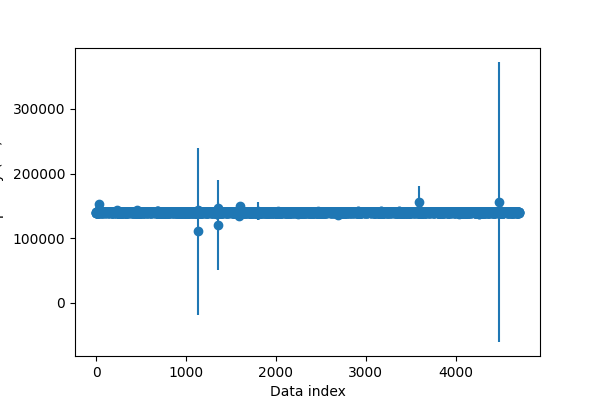

In [339]:
fs = unumpy.nominal_values(all_results["freq_center"])
fs_err = unumpy.std_devs(all_results["freq_center"])

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(fs)), fs, fs_err, fmt="o", ls="none")

ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency (Hz)")
plt.show()

In [340]:
import onix.models.hyperfine as hyperfine
magnetic_field = 223e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(magnetic_field)
e_g, s_g = ground.energies_and_eigenstates()

a_I_dot_n = (s_g[0].dag() * ground._I_x * s_g[0]).tr()
abar_I_dot_n = (s_g[1].dag() * ground._I_x * s_g[1]).tr()
b_I_dot_n = (s_g[2].dag() * ground._I_x * s_g[2]).tr()
bbar_I_dot_n = (s_g[3].dag() * ground._I_x * s_g[3]).tr()
I_a = (abar_I_dot_n - a_I_dot_n) / 2
I_b = (bbar_I_dot_n - b_I_dot_n) / 2

def combine_polarization_data(results):
    def check_equal_and_append(check_from, check_name, append_to):
        check_col = check_from[:, col_indices[check_name]]
        count = np.unique(check_col)
        if len(count) > 1:
            raise Exception(f"{check_name} is not the same.")
        append_to.append(check_col[0])

    results_array = pandas.DataFrame.from_dict(results).to_numpy()
    keys = list(results.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = {
        "f+": [], "f-": [], "E": [], "detect_red_first": [], "start_time": [], "end_time": [], "state": [], "data_indices": [],
        "field_plate_amplitude": [], "electric_field_shift_MHz": [], "center_freq_kHz": [],
        "Z": [], "W_T": [],
        "detect_amplitude": [], "detect_cycles": [],
    }
    for kk in range(len(results_array) // 2):
        sub_data = results_array[kk * 2: kk * 2 + 2]
        data_indices = []
        check_equal_and_append(sub_data, "E", data["E"])
        check_equal_and_append(sub_data, "detect_red_first", data["detect_red_first"])
        check_equal_and_append(sub_data, "state", data["state"])
        check_equal_and_append(sub_data, "field_plate_amplitude", data["field_plate_amplitude"])
        check_equal_and_append(sub_data, "stark_shift_MHz", data["electric_field_shift_MHz"])
        check_equal_and_append(sub_data, "center_freq_kHz", data["center_freq_kHz"])
        check_equal_and_append(sub_data, "detect_amplitude", data["detect_amplitude"])
        check_equal_and_append(sub_data, "detect_cycles", data["detect_cycles"])
        for ll, datapoint in enumerate(sub_data):
            if ll == 0:
                start_time = datapoint[col_indices["start_time"]]
            if ll == len(sub_data) - 1:
                end_time = datapoint[col_indices["end_time"]]
                
            data_indices.extend(datapoint[col_indices["data_indices"]])
            if datapoint[col_indices["D"]]:
                f_p = datapoint[col_indices["freq_center"]]
            else:
                f_m = datapoint[col_indices["freq_center"]]

        data["f+"].append(f_p)
        data["f-"].append(f_m)
        data["start_time"].append(start_time)
        data["end_time"].append(end_time)
        data["data_indices"].append(data_indices)

    data["f+"] = np.array(data["f+"])
    data["f-"] = np.array(data["f-"])
    data["Z"] = (data["f+"] + data["f-"]) / 4
    data["W_T"] = []
    for kk in range(len(data["f+"])):
        if data["state"][kk] == "a":
            I = I_a
        else:
            I = I_b
        data["W_T"].append((data["f+"][kk] - data["f-"][kk]) / 4 / I)

    keys = list(data.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = pandas.DataFrame.from_dict(data).to_numpy()
    return data, col_indices

In [341]:
results, col_indices = combine_polarization_data(all_results)

In [342]:
a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

#W_T_aa_p = 

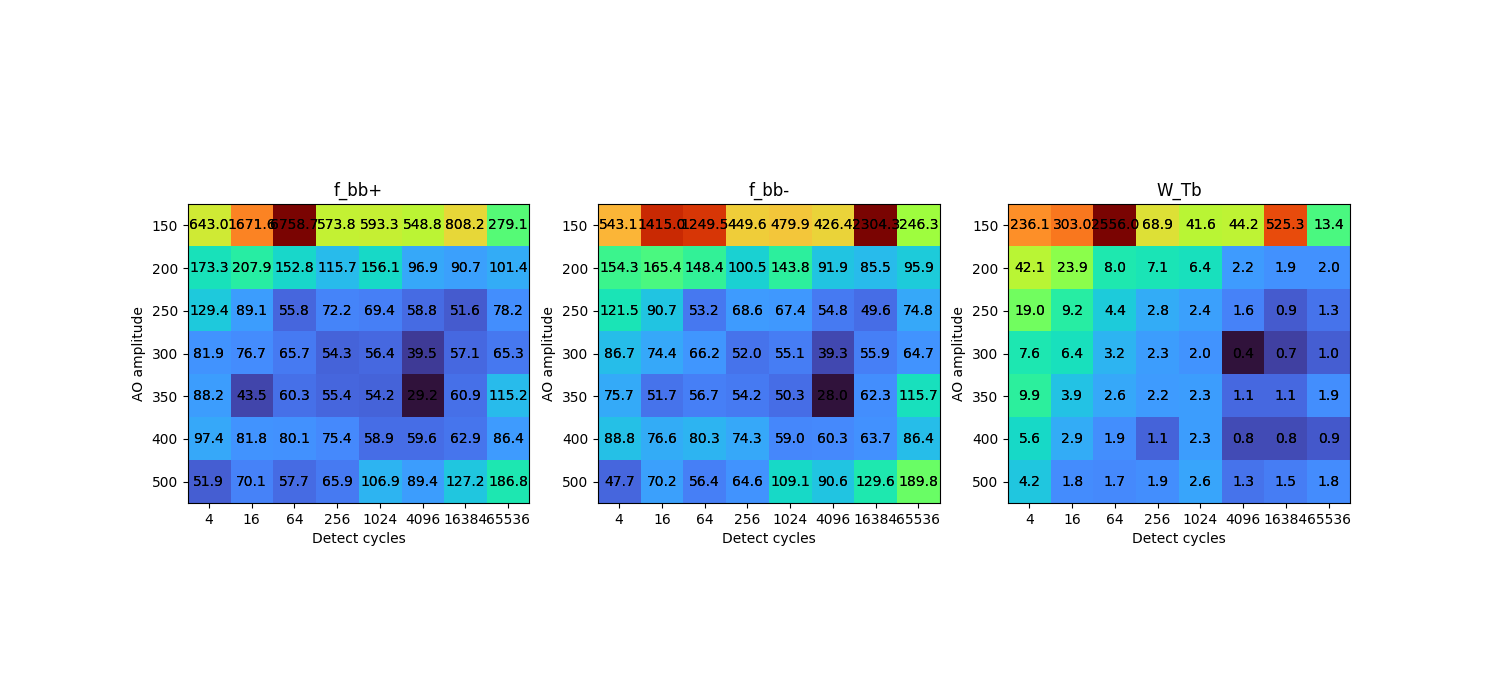

In [343]:
f_ps = []
f_ms = []
f_Ws = []

mask_E_positive = results[:, col_indices["E"]] == False
mask_light_on = np.ones(len(results[:, 0]), dtype=bool)
for ll in range(500):
    mask_light_on[-ll] = False
for amplitude in np.unique(results[:, col_indices["detect_amplitude"]]):
    f_ps.append([])
    f_ms.append([])
    f_Ws.append([])
    mask_amplitude = results[:, col_indices["detect_amplitude"]] == amplitude
    for cycles in np.unique(results[:, col_indices["detect_cycles"]]):
        mask_cycles = results[:, col_indices["detect_cycles"]] == cycles
        data_masked = results[mask_light_on & mask_amplitude & mask_cycles & mask_E_positive]
        # print(amplitude, cycles, np.std(unumpy.nominal_values(data_masked[:, col_indices["f+"]])))
        # print(amplitude, cycles, np.std(unumpy.nominal_values(data_masked[:, col_indices["f-"]])))
        # print(amplitude, cycles, np.std(unumpy.nominal_values(data_masked[:, col_indices["W_T"]])))
        f_ps[-1].append(np.std(unumpy.nominal_values(data_masked[:, col_indices["f+"]])))
        f_ms[-1].append(np.std(unumpy.nominal_values(data_masked[:, col_indices["f-"]])))
        f_Ws[-1].append(np.std(unumpy.nominal_values(data_masked[:, col_indices["W_T"]])))

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(f_ps, norm="log", cmap="turbo")
ax[0].set_yticks(list(range(7)))
ax[0].set_yticklabels(np.unique(results[:, col_indices["detect_amplitude"]]))
ax[0].set_xticks(list(range(8)))
ax[0].set_xticklabels(np.unique(results[:, col_indices["detect_cycles"]]))
ax[0].set_ylabel("AO amplitude")
ax[0].set_xlabel("Detect cycles")
ax[0].set_title("f_bb+")
for (j,i),label in np.ndenumerate(f_ps):
    ax[0].text(i,j,f"{label:.1f}",ha='center',va='center')
    ax[0].text(i,j,f"{label:.1f}",ha='center',va='center')

ax[1].imshow(f_ms, norm="log", cmap="turbo")
ax[1].set_yticks(list(range(7)))
ax[1].set_yticklabels(np.unique(results[:, col_indices["detect_amplitude"]]))
ax[1].set_xticks(list(range(8)))
ax[1].set_xticklabels(np.unique(results[:, col_indices["detect_cycles"]]))
ax[1].set_ylabel("AO amplitude")
ax[1].set_xlabel("Detect cycles")
ax[1].set_title("f_bb-")
for (j,i),label in np.ndenumerate(f_ms):
    ax[1].text(i,j,f"{label:.1f}",ha='center',va='center')
    ax[1].text(i,j,f"{label:.1f}",ha='center',va='center')
    
ax[2].imshow(f_Ws, norm="log", cmap="turbo")
ax[2].set_yticks(list(range(7)))
ax[2].set_yticklabels(np.unique(results[:, col_indices["detect_amplitude"]]))
ax[2].set_xticks(list(range(8)))
ax[2].set_xticklabels(np.unique(results[:, col_indices["detect_cycles"]]))
ax[2].set_ylabel("AO amplitude")
ax[2].set_xlabel("Detect cycles")
ax[2].set_title("W_Tb")
for (j,i),label in np.ndenumerate(f_Ws):
    ax[2].text(i,j,f"{label:.1f}",ha='center',va='center')
    ax[2].text(i,j,f"{label:.1f}",ha='center',va='center')
plt.show()

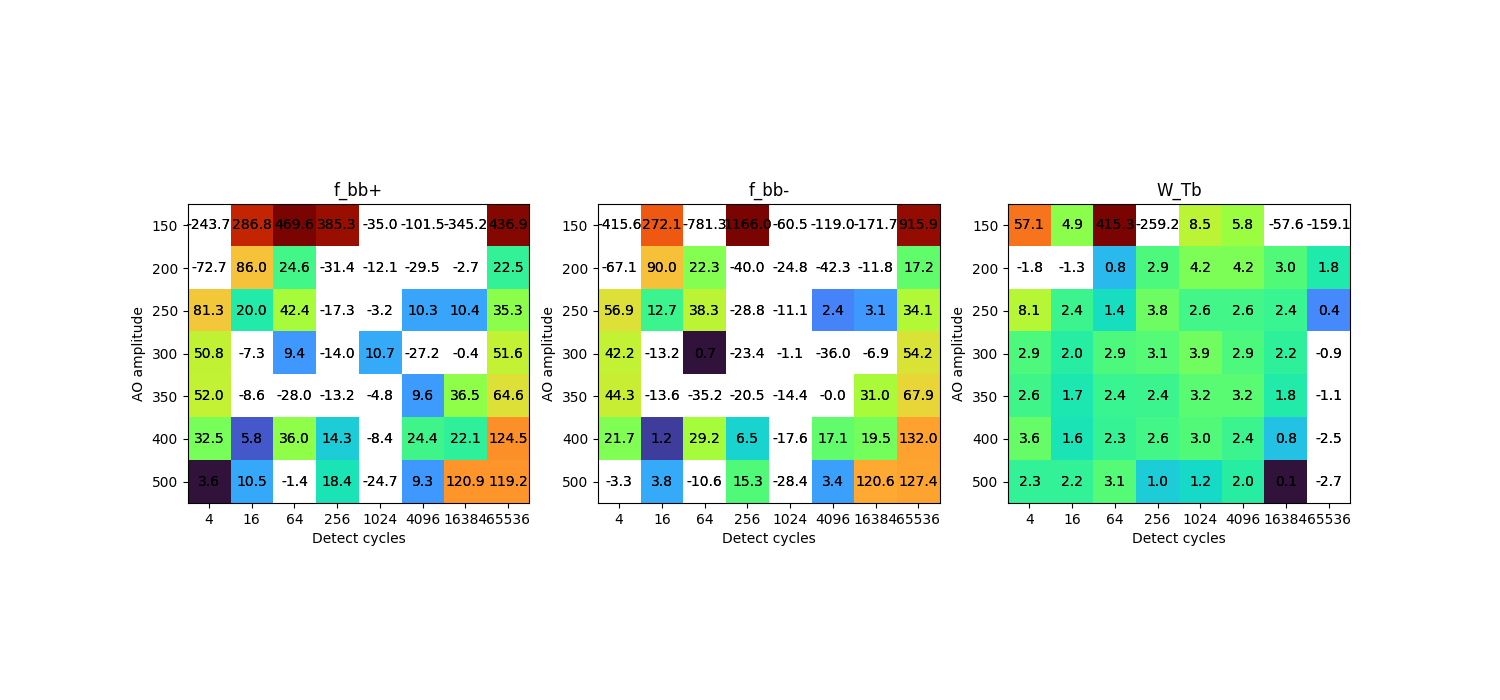

In [344]:
f_ps = []
f_ms = []
f_Ws = []

mask_E_positive = results[:, col_indices["E"]] == True
mask_light_on = np.ones(len(results[:, 0]), dtype=bool)
for ll in range(500):
    mask_light_on[-ll] = False
for amplitude in np.unique(results[:, col_indices["detect_amplitude"]]):
    f_ps.append([])
    f_ms.append([])
    f_Ws.append([])
    mask_amplitude = results[:, col_indices["detect_amplitude"]] == amplitude
    for cycles in np.unique(results[:, col_indices["detect_cycles"]]):
        mask_cycles = results[:, col_indices["detect_cycles"]] == cycles
        data_masked = results[mask_light_on & mask_amplitude & mask_cycles & mask_E_positive]
        # print(amplitude, cycles, np.std(unumpy.nominal_values(data_masked[:, col_indices["f+"]])))
        # print(amplitude, cycles, np.std(unumpy.nominal_values(data_masked[:, col_indices["f-"]])))
        # print(amplitude, cycles, np.std(unumpy.nominal_values(data_masked[:, col_indices["W_T"]])))
        f_ps[-1].append(np.average(unumpy.nominal_values(data_masked[:, col_indices["f+"]])) - 139700)
        f_ms[-1].append(np.average(unumpy.nominal_values(data_masked[:, col_indices["f-"]])) - 139700)
        f_Ws[-1].append(np.average(unumpy.nominal_values(data_masked[:, col_indices["W_T"]])))

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(f_ps, norm="log", cmap="turbo")
ax[0].set_yticks(list(range(7)))
ax[0].set_yticklabels(np.unique(results[:, col_indices["detect_amplitude"]]))
ax[0].set_xticks(list(range(8)))
ax[0].set_xticklabels(np.unique(results[:, col_indices["detect_cycles"]]))
ax[0].set_ylabel("AO amplitude")
ax[0].set_xlabel("Detect cycles")
ax[0].set_title("f_bb+")
for (j,i),label in np.ndenumerate(f_ps):
    ax[0].text(i,j,f"{label:.1f}",ha='center',va='center')
    ax[0].text(i,j,f"{label:.1f}",ha='center',va='center')

ax[1].imshow(f_ms, norm="log", cmap="turbo")
ax[1].set_yticks(list(range(7)))
ax[1].set_yticklabels(np.unique(results[:, col_indices["detect_amplitude"]]))
ax[1].set_xticks(list(range(8)))
ax[1].set_xticklabels(np.unique(results[:, col_indices["detect_cycles"]]))
ax[1].set_ylabel("AO amplitude")
ax[1].set_xlabel("Detect cycles")
ax[1].set_title("f_bb-")
for (j,i),label in np.ndenumerate(f_ms):
    ax[1].text(i,j,f"{label:.1f}",ha='center',va='center')
    ax[1].text(i,j,f"{label:.1f}",ha='center',va='center')
    
ax[2].imshow(f_Ws, norm="log", cmap="turbo")
ax[2].set_yticks(list(range(7)))
ax[2].set_yticklabels(np.unique(results[:, col_indices["detect_amplitude"]]))
ax[2].set_xticks(list(range(8)))
ax[2].set_xticklabels(np.unique(results[:, col_indices["detect_cycles"]]))
ax[2].set_ylabel("AO amplitude")
ax[2].set_xlabel("Detect cycles")
ax[2].set_title("W_Tb")
for (j,i),label in np.ndenumerate(f_Ws):
    ax[2].text(i,j,f"{label:.1f}",ha='center',va='center')
    ax[2].text(i,j,f"{label:.1f}",ha='center',va='center')
plt.show()

In [331]:
# Code for E field sweep
E_field_magnitude = []
splitting = []
uncertainty_splitting = []

W_T = W_T_a

for kk, E_mask in enumerate(E_masks):
    print(E_fields[kk])
    W_T_avg = np.average(W_T[E_mask]).n
    W_T_ste = np.std(unumpy.nominal_values(W_T[E_mask])) / np.sqrt(len(W_T[E_mask]))
    print("Average W_T =", present_float(W_T_avg, W_T_ste), "Hz")
    W_T_p_avg = np.average(W_T[E_mask & E_pos_mask]).n
    W_T_p_ste = np.std(unumpy.nominal_values(W_T[E_mask & E_pos_mask])) / np.sqrt(len(W_T[E_mask & E_pos_mask]))
    #print("Average W_T+ =", present_float(W_T_p_avg, W_T_p_ste), "Hz")
    W_T_m_avg = np.average(W_T[E_mask & E_neg_mask]).n
    W_T_m_ste = np.std(unumpy.nominal_values(W_T[E_mask & E_neg_mask])) / np.sqrt(len(W_T[E_mask & E_neg_mask]))
    #print("Average W_T- =", present_float(W_T_m_avg, W_T_m_ste), "Hz")
    W_T_p_minus_W_T_m = W_T_p_avg - W_T_m_avg
    uncertainty_W_T_p_minus_W_T_m = np.sqrt(W_T_p_ste**2 + W_T_m_ste**2)
    print(f'W_T+ - W_T- = {present_float(W_T_p_minus_W_T_m,uncertainty_W_T_p_minus_W_T_m)}')
    E_field_magnitude.append(E_fields[kk])
    splitting.append(W_T_p_minus_W_T_m)
    uncertainty_splitting.append(uncertainty_W_T_p_minus_W_T_m)

4500.0
Average W_T = 1.0(5) Hz
W_T+ - W_T- = -0.3(9)
6750.0
Average W_T = -1.0(1.0) Hz
W_T+ - W_T- = 9.4(1.4)
9000.0
Average W_T = -1(2) Hz
W_T+ - W_T- = 27.7(1.6)
11250.0
Average W_T = 0(5) Hz
W_T+ - W_T- = 61.4(1.9)
13500.0
Average W_T = 1(8) Hz
W_T+ - W_T- = 101(3)


[]

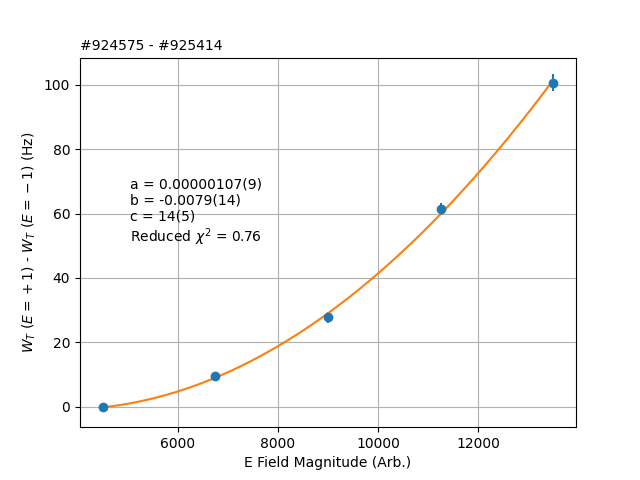

In [332]:
# Code for E Field Sweep
fitter = Fitter(quadratic)
fitter.set_data(E_field_magnitude, splitting,uncertainty_splitting)
fitter.set_absolute_sigma(True)
fitter.fit()
E_axis = np.linspace(min(E_field_magnitude), np.max(E_field_magnitude), 1000)
fitted_splitting = fitter.fitted_value(E_axis)

fig, ax = plt.subplots()
ax.errorbar(E_field_magnitude, splitting, uncertainty_splitting, fmt = 'o')
ax.plot(E_axis,fitted_splitting)
ax.set_xlabel("E Field Magnitude (Arb.)")
ax.set_ylabel(r"$W_T$ $(E = +1)$ - $W_T$ $(E = -1)$ (Hz)")
ax.grid()
ax.text(0.1,0.5,s = fitter.all_results_str(), transform = ax.transAxes)
ax.text(0,1.02, s= f"#{first} - #{last}", transform = ax.transAxes)
plt.plot()

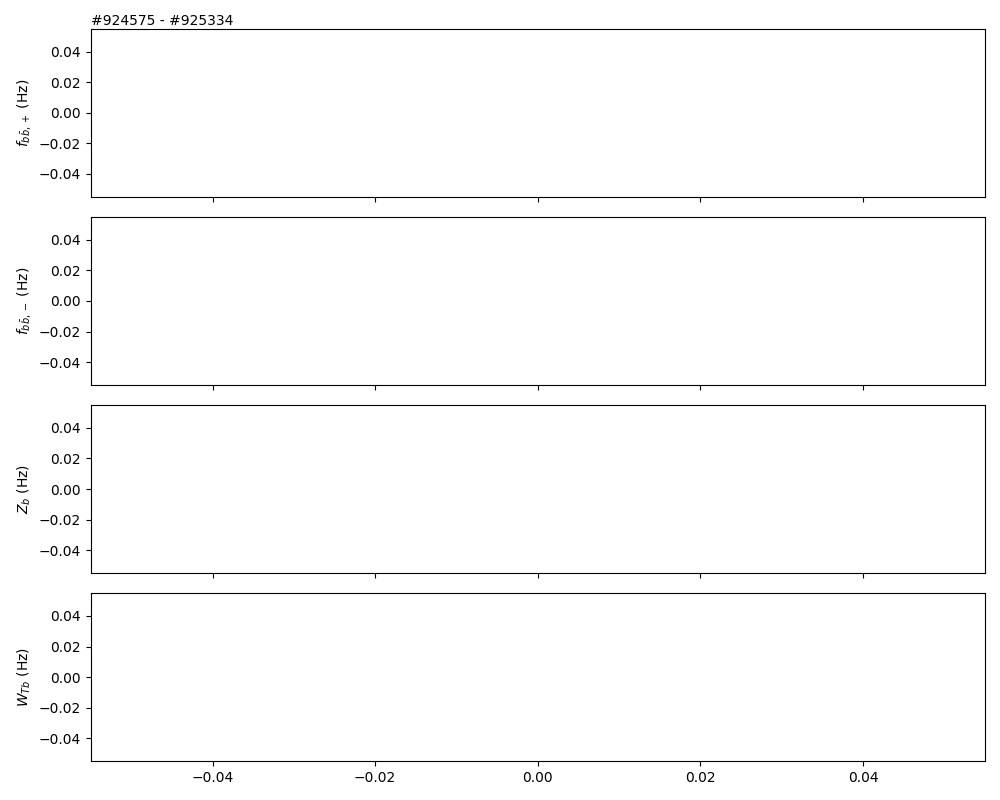

In [320]:
#mask_amplitude = results[:, col_indices["detect_amplitude"]] == 350
#mask_cycles = results[:, col_indices["detect_cycles"]] == 4096 #65536

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

errorbar_args = {"fmt": "o", "ls": "none"}

axs[0].set_ylabel("$f_{b\\bar{b}, +}$ (Hz)")
axs[1].set_ylabel("$f_{b\\bar{b}, -}$ (Hz)")
axs[2].set_ylabel("$Z_b$ (Hz)")
axs[3].set_ylabel("$W_{Tb}$ (Hz)")
for kk, d in enumerate([f_p_b, f_m_b, Z_b, W_T_b]):
    axs[kk].errorbar(
        start_times_b, unumpy.nominal_values(d), unumpy.std_devs(d),
        **errorbar_args
    )
axs[0].text(0,1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()

0.22936758057633536
0.7806286248355983


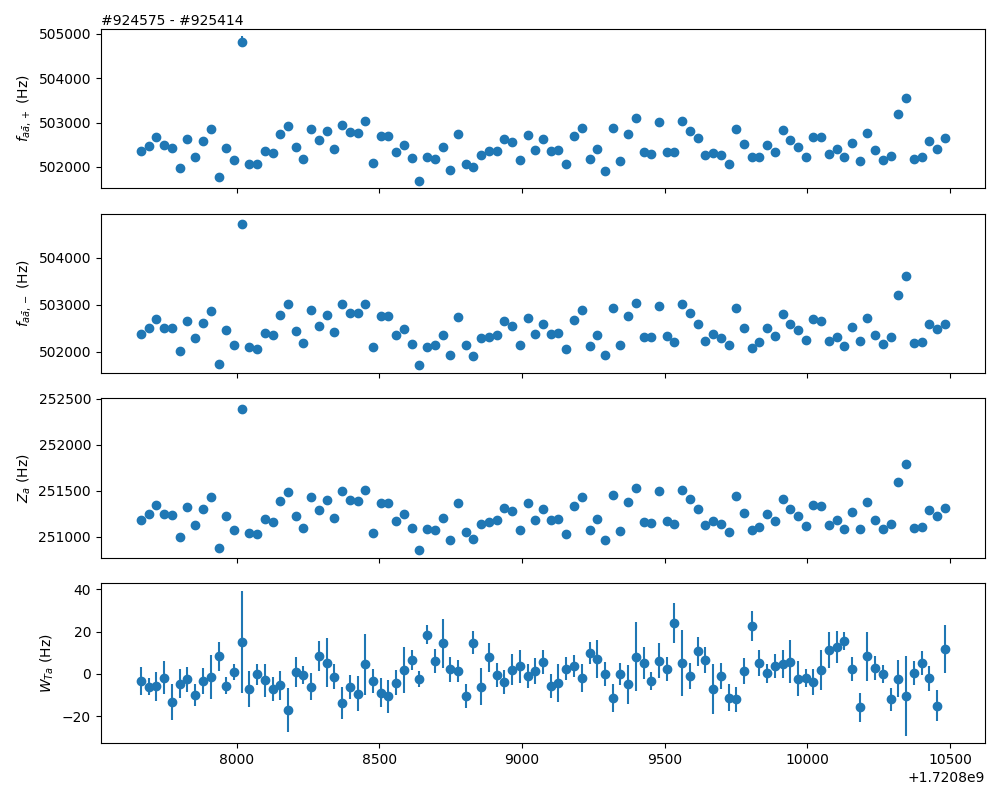

In [337]:
#mask_amplitude = results[:, col_indices["detect_amplitude"]] == 350
#mask_cycles = results[:, col_indices["detect_cycles"]] == 4096 #65536

E_pos = results[:, col_indices["E"]] == True
E_neg = results[:, col_indices["E"]] == False

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

errorbar_args = {"fmt": "o", "ls": "none"}

axs[0].set_ylabel("$f_{a\\bar{a}, +}$ (Hz)")
axs[1].set_ylabel("$f_{a\\bar{a}, -}$ (Hz)")
axs[2].set_ylabel("$Z_a$ (Hz)")
axs[3].set_ylabel("$W_{Ta}$ (Hz)")
for kk, d in enumerate([f_p_a, f_m_a, Z_a, W_T_a]):
    axs[kk].errorbar(
        start_times_a[E_pos], unumpy.nominal_values(d)[E_pos] + unumpy.nominal_values(d)[E_neg], unumpy.std_devs(d[E_pos] + d[E_neg]),
        **errorbar_args
    )
print(np.average(unumpy.nominal_values(W_T_a)[E_pos] + unumpy.nominal_values(W_T_a)[E_neg]))
print(np.std(unumpy.nominal_values(W_T_a)[E_pos] + unumpy.nominal_values(W_T_a)[E_neg]) / np.sqrt(len(unumpy.nominal_values(W_T_a)[E_pos])))
axs[0].text(0,1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (0,) (7,) 

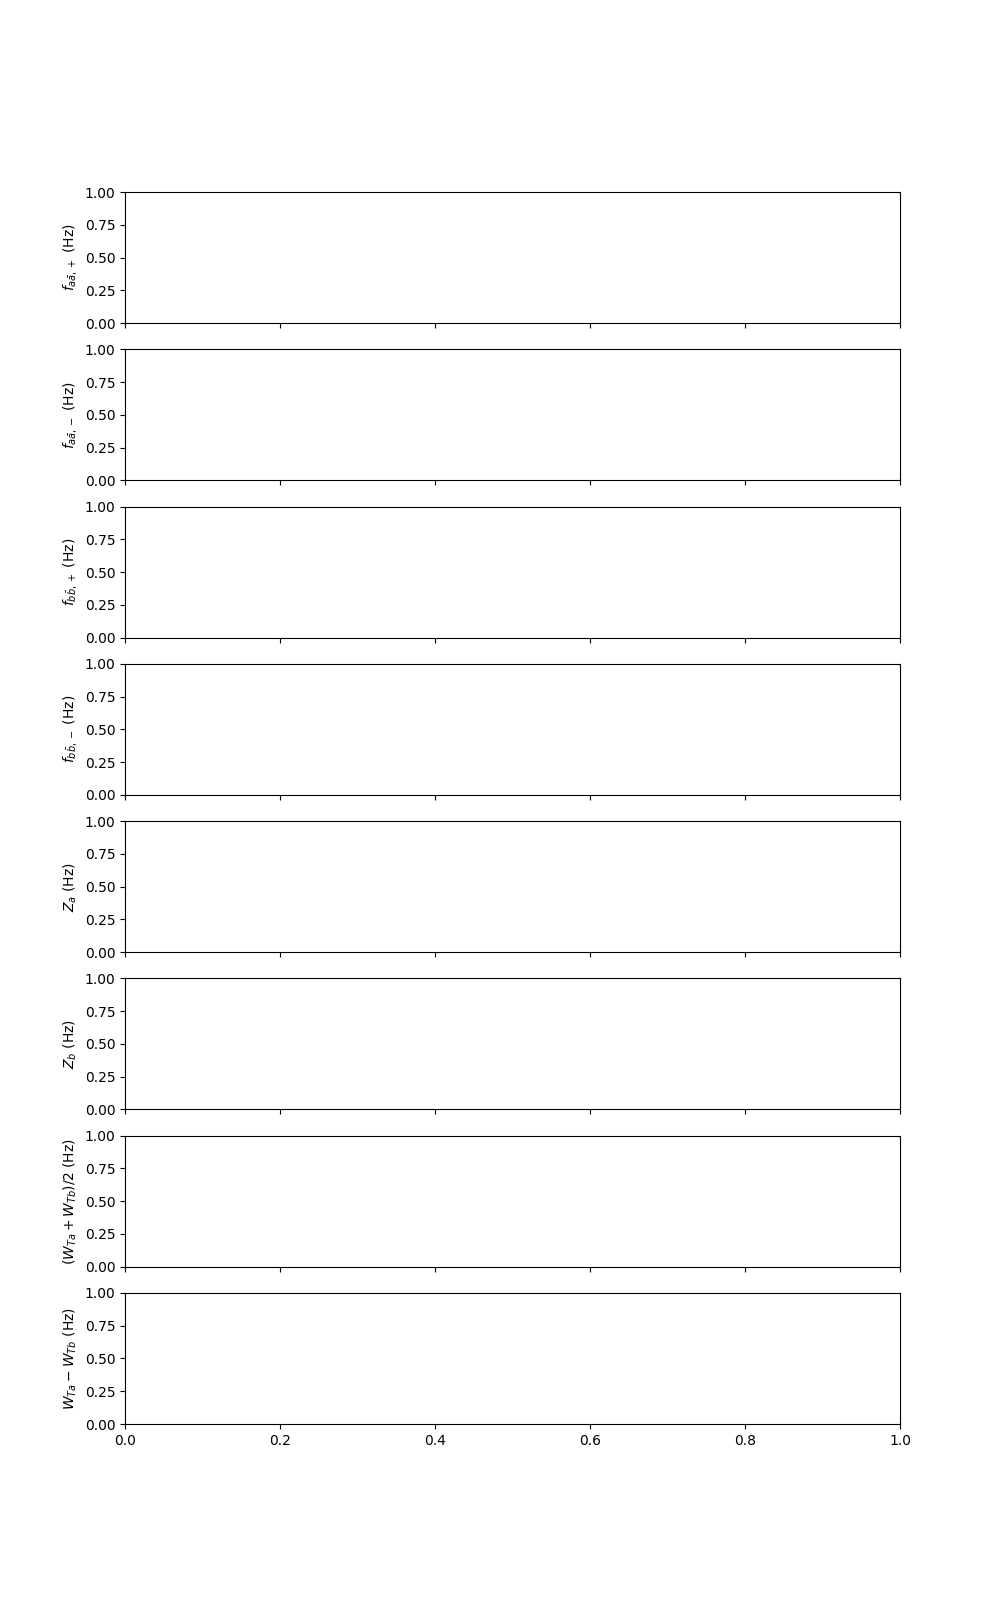

In [189]:
fig, axs = plt.subplots(8, 1, sharex=True, figsize=(10, 16))

errorbar_args = {"fmt": "o", "ls": "none"}

axs[0].set_ylabel("$f_{a\\bar{a}, +}$ (Hz)")
axs[1].set_ylabel("$f_{a\\bar{a}, -}$ (Hz)")
axs[2].set_ylabel("$f_{b\\bar{b}, +}$ (Hz)")
axs[3].set_ylabel("$f_{b\\bar{b}, -}$ (Hz)")
axs[4].set_ylabel("$Z_a$ (Hz)")
axs[5].set_ylabel("$Z_b$ (Hz)")
axs[6].set_ylabel("$(W_{Ta} + W_{Tb}) / 2$ (Hz)")
axs[7].set_ylabel("$W_{Ta} - W_{Tb}$ (Hz)")
for kk, d in enumerate([f_p_a, f_m_a, f_p_b, f_m_b, Z_a, Z_b, (W_T_a + W_T_b) / 2, W_T_a - W_T_b]):
    axs[kk].errorbar(
        start_times_a, unumpy.nominal_values(d), unumpy.std_devs(d),
        **errorbar_args
    )
plt.tight_layout()
plt.show()